In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from diffusers import UNet2DModel, DDPMScheduler

# Load and Preprocess Dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define Model and Scheduler
class SimpleDDPM(nn.Module):
    def __init__(self):
        super(SimpleDDPM, self).__init__()
        self.model = UNet2DModel(
            sample_size=32,
            in_channels=1,
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(64, 128, 256, 512),
            down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"),
            up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D")
        )

    def forward(self, x, t):
        return self.model(x, t).sample

# Initialize the model and scheduler
model = SimpleDDPM().to('cuda')
scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()


In [9]:
from tqdm import tqdm
def train(model, scheduler, criterion, optimizer, dataloader, epochs=100, device='cuda'):
    model.to(device)
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        for batch in tqdm(dataloader):
            images, _ = batch
            images = images.to(device)
            t = torch.randint(0, scheduler.config.num_train_timesteps, (images.size(0),), device=device).long()
            noise = torch.randn_like(images).to(device)
            noisy_images = scheduler.add_noise(original_samples=images, noise=noise, timesteps=t)

            optimizer.zero_grad()
            predicted_noise = model(noisy_images, t)
            loss = criterion(predicted_noise, noise)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")

        # Save model checkpoints periodically
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), f"ddpm_mnist_epoch{epoch + 1}.pth")

# Run the training function
train(model, scheduler, criterion, optimizer, train_loader, epochs=100)


100%|██████████| 938/938 [00:48<00:00, 19.27it/s]


Epoch 1/100, Loss: 0.020269332331484122


  3%|▎         | 31/938 [00:01<00:50, 18.07it/s]


KeyboardInterrupt: 

In [10]:
# Generate and Visualize Images
model.eval()
with torch.no_grad():
    num_images = 10
    noise = torch.randn(num_images, 1, 32, 32).to('cuda')
    for t in reversed(range(scheduler.config.num_train_timesteps)):
        noise = scheduler.step(model, t, noise).prev_sample

    generated_images = (noise + 1) / 2  # Convert [-1, 1] to [0, 1]

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, num_images, figsize=(20, 2))
for i in range(num_images):
    axs[i].imshow(generated_images[i].cpu().squeeze(), cmap="gray")
    axs[i].axis("off")
plt.show()


AttributeError: 'SimpleDDPM' object has no attribute 'shape'

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from diffusers import UNet2DModel, DDPMScheduler
from tqdm import tqdm
# Load and Preprocess Dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define Model and Scheduler
class SimpleDDPM(nn.Module):
    def __init__(self):
        super(SimpleDDPM, self).__init__()
        self.model = UNet2DModel(
            sample_size=32,
            in_channels=1,
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(64, 128, 256, 512),
            down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"),
            up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D")
        )

    def forward(self, x, t):
        return self.model(x, t).sample

# Initialize the model and scheduler
model = SimpleDDPM().to('cuda')
scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Custom Training Function
def train(model, scheduler, criterion, optimizer, dataloader, epochs=100, device='cuda'):
    model.to(device)
    model.train()

    for epoch in tqdm(range(epochs)):
        epoch_loss = 0
        for batch in dataloader:
            images, _ = batch
            images = images.to(device)
            t = torch.randint(0, scheduler.config.num_train_timesteps, (images.size(0),), device=device).long()
            noise = torch.randn_like(images).to(device)
            noisy_images = scheduler.add_noise(original_samples=images, noise=noise, timesteps=t)

            optimizer.zero_grad()
            predicted_noise = model(noisy_images, t)
            loss = criterion(predicted_noise, noise)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")

        # Save model checkpoints periodically
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), f"ddpm_mnist_epoch{epoch + 1}.pth")

# Run the training function
train(model, scheduler, criterion, optimizer, train_loader, epochs=100)


  1%|          | 1/100 [00:49<1:21:15, 49.25s/it]

Epoch 1/100, Loss: 0.03971797956733593


  2%|▏         | 2/100 [01:36<1:18:30, 48.07s/it]

Epoch 2/100, Loss: 0.021147790351020757


  3%|▎         | 3/100 [02:23<1:16:37, 47.40s/it]

Epoch 3/100, Loss: 0.019066537970673047


  4%|▍         | 4/100 [03:09<1:15:18, 47.07s/it]

Epoch 4/100, Loss: 0.017913723559077107


  5%|▌         | 5/100 [03:56<1:14:25, 47.00s/it]

Epoch 5/100, Loss: 0.017176428591328136


  6%|▌         | 6/100 [04:43<1:13:38, 47.01s/it]

Epoch 6/100, Loss: 0.01674911572929543


  7%|▋         | 7/100 [05:30<1:12:41, 46.90s/it]

Epoch 7/100, Loss: 0.01653275225879446


  8%|▊         | 8/100 [06:17<1:11:55, 46.91s/it]

Epoch 8/100, Loss: 0.016507437083322102


  9%|▉         | 9/100 [07:04<1:11:27, 47.11s/it]

Epoch 9/100, Loss: 0.0160174648632913
Epoch 10/100, Loss: 0.016041591831012322


 11%|█         | 11/100 [08:41<1:10:49, 47.75s/it]

Epoch 11/100, Loss: 0.015727979763508287


 12%|█▏        | 12/100 [09:28<1:09:20, 47.27s/it]

Epoch 12/100, Loss: 0.01566966178952091


 13%|█▎        | 13/100 [10:17<1:09:25, 47.88s/it]

Epoch 13/100, Loss: 0.015479539032540977


 14%|█▍        | 14/100 [11:06<1:09:16, 48.33s/it]

Epoch 14/100, Loss: 0.015493055608973447


 15%|█▌        | 15/100 [11:54<1:08:23, 48.27s/it]

Epoch 15/100, Loss: 0.015324854700049675


 16%|█▌        | 16/100 [12:41<1:06:43, 47.66s/it]

Epoch 16/100, Loss: 0.01522892543664778


 17%|█▋        | 17/100 [13:27<1:05:27, 47.31s/it]

Epoch 17/100, Loss: 0.015077013652453989


 18%|█▊        | 18/100 [14:14<1:04:38, 47.30s/it]

Epoch 18/100, Loss: 0.015055431869190766


 19%|█▉        | 19/100 [15:02<1:03:53, 47.33s/it]

Epoch 19/100, Loss: 0.015184384784591732
Epoch 20/100, Loss: 0.014913661258497727


 21%|██        | 21/100 [16:38<1:02:45, 47.66s/it]

Epoch 21/100, Loss: 0.014924514890789414


 22%|██▏       | 22/100 [17:26<1:02:11, 47.84s/it]

Epoch 22/100, Loss: 0.014873380282286134


 23%|██▎       | 23/100 [18:13<1:01:04, 47.59s/it]

Epoch 23/100, Loss: 0.01501040482945216


 24%|██▍       | 24/100 [19:02<1:00:40, 47.90s/it]

Epoch 24/100, Loss: 0.014806035930898461


 25%|██▌       | 25/100 [19:50<1:00:11, 48.16s/it]

Epoch 25/100, Loss: 0.014830532828286322


 26%|██▌       | 26/100 [20:38<59:23, 48.16s/it]  

Epoch 26/100, Loss: 0.01480949465443553


 27%|██▋       | 27/100 [21:27<58:33, 48.13s/it]

Epoch 27/100, Loss: 0.014766516278622977


 28%|██▊       | 28/100 [22:15<57:51, 48.21s/it]

Epoch 28/100, Loss: 0.014789448713442918


 29%|██▉       | 29/100 [23:02<56:28, 47.73s/it]

Epoch 29/100, Loss: 0.014643195567767758
Epoch 30/100, Loss: 0.014638517868579991


 31%|███       | 31/100 [24:39<55:35, 48.34s/it]

Epoch 31/100, Loss: 0.014578459868783445


 32%|███▏      | 32/100 [25:28<55:00, 48.54s/it]

Epoch 32/100, Loss: 0.014602928186085686


 33%|███▎      | 33/100 [26:18<54:39, 48.95s/it]

Epoch 33/100, Loss: 0.014566722193927462


 34%|███▍      | 34/100 [27:05<53:09, 48.32s/it]

Epoch 34/100, Loss: 0.014600173795103297


 35%|███▌      | 35/100 [27:52<51:56, 47.94s/it]

Epoch 35/100, Loss: 0.014366539453329054


 36%|███▌      | 36/100 [28:40<51:08, 47.95s/it]

Epoch 36/100, Loss: 0.014524193485575253


 37%|███▋      | 37/100 [29:27<49:59, 47.61s/it]

Epoch 37/100, Loss: 0.0143738122108871


 38%|███▊      | 38/100 [30:14<49:04, 47.49s/it]

Epoch 38/100, Loss: 0.014503788155342725


 39%|███▉      | 39/100 [31:03<48:53, 48.09s/it]

Epoch 39/100, Loss: 0.014484303511941294
Epoch 40/100, Loss: 0.014422788684850118


 41%|████      | 41/100 [32:39<47:11, 47.99s/it]

Epoch 41/100, Loss: 0.014436094775430557


 42%|████▏     | 42/100 [33:27<46:15, 47.85s/it]

Epoch 42/100, Loss: 0.014411060114714828


 43%|████▎     | 43/100 [34:14<45:14, 47.62s/it]

Epoch 43/100, Loss: 0.01415978077807025


 44%|████▍     | 44/100 [35:00<44:08, 47.30s/it]

Epoch 44/100, Loss: 0.014310292270121925


 44%|████▍     | 44/100 [35:13<44:50, 48.04s/it]


KeyboardInterrupt: 

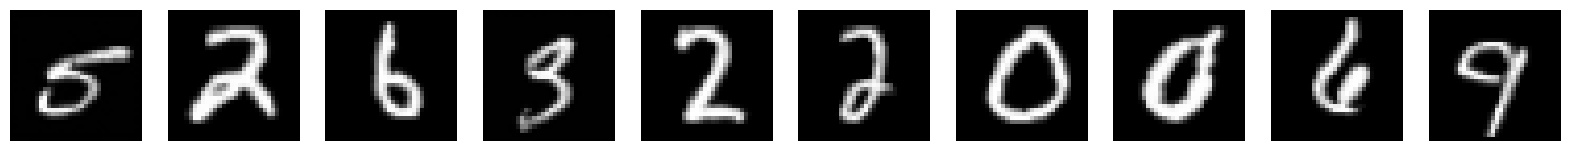

In [12]:
# Generate and Visualize Images
model.eval()
with torch.no_grad():
    num_images = 10
    noise = torch.randn(num_images, 1, 32, 32).to('cuda')
    for t in reversed(range(scheduler.config.num_train_timesteps)):
        # Generate model output for the current timestep
        model_output = model(noise, t)
        # Use the scheduler to step
        noise = scheduler.step(model_output, t, noise).prev_sample

    generated_images = (noise + 1) / 2  # Convert [-1, 1] to [0, 1]

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, num_images, figsize=(20, 2))
for i in range(num_images):
    axs[i].imshow(generated_images[i].cpu().squeeze(), cmap="gray")
    axs[i].axis("off")
plt.show()